In [6]:
!cd .. && maturin build --release

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.9 at python3.9
📦 Built source distribution to /home/ubuntu/omelette/target/wheels/rejoice-0.1.0.tar.gz
    Finished release [optimized] target(s) in 0.03s
📦 Built wheel for CPython 3.9 to /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl


In [7]:
%pip install /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl --force-reinstall

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Processing /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl
  Attempting uninstall: rejoice
    Found existing installation: rejoice 0.1.0
    Uninstalling rejoice-0.1.0:
      Successfully uninstalled rejoice-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('..')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import groupby
from collections import namedtuple
import math
import time
from PropLang import PropLang
from MathLang import MathLang
import rejoice
from rejoice import EGraph
from rejoice.lib import Language
from rejoice.pretrain_dataset_gen import EGraphSolver

/home/ubuntu/anaconda3/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-13 20:44:21.388069: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# !sudo apt install --yes cm-super dvipng texlive-fonts-recommended texlive-latex-extra texlive-latex-recommended

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['font.size'] = 18

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Limitations of Equality Saturation

In [3]:
def run_egg(lang: Language, expr, node_limit=10_000, iter_limit=7):
    print(f"running egg for expr", expr)
    first_stamp = int(round(time.time() * 1000))
    egraph = EGraph()
    egraph.add(expr)
    stop_reason, num_applications, num_enodes, num_eclasses = egraph.run(lang.rewrite_rules(), iter_limit=iter_limit, node_limit=node_limit)
    print(stop_reason, "num_applications", num_applications, "num_enodes", num_enodes, "num_eclasses", num_eclasses)
    best_cost, best_expr = egraph.extract(expr)
    second_stamp = int(round(time.time() * 1000))
    # Calculate the time taken in milliseconds
    time_taken = second_stamp - first_stamp
    # egraph.graphviz("egg_best.png")
    print(f"egg best cost:", best_cost, "in",
            f"{time_taken}ms", "best expr: ", best_expr)
    return best_cost, best_expr, num_applications, num_enodes

running egg for expr Or(x=And(x='x', y='y'), y=Implies(x='x', y='z'))
NODE_LIMIT num_applications 588 num_enodes 1133 num_eclasses 255
egg best cost: 5 in 2ms best expr:  Or(x='z', y=Implies(x='x', y='y'))
matched egg cost. Finding minimum sequence...
[0, 3, 4, 7, 8, 12, 2, 3, 4, 6, 7, 9, 11, 12, 2]
found best 5.0 Or(x='z', y=Implies(x='x', y='y')) [0, 4, 7, 8, 6, 7, 9, 11, 2, 13]
hit node limit when searching...


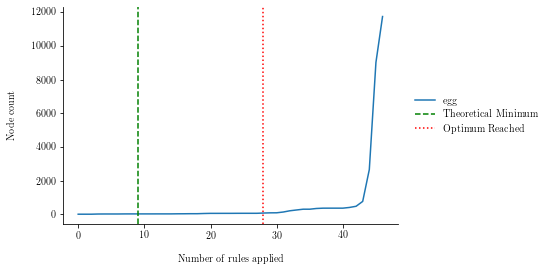

In [7]:
lang = PropLang()
ops = lang.all_operators_dict()
AND, NOT, OR, IM = ops["and"], ops["not"], ops["or"], ops["implies"]
x, y, z = "x", "y", "z"
expr = OR(AND(x, y), IM(x, z))
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count.pdf", bbox_inches='tight')


hit node limit when searching...


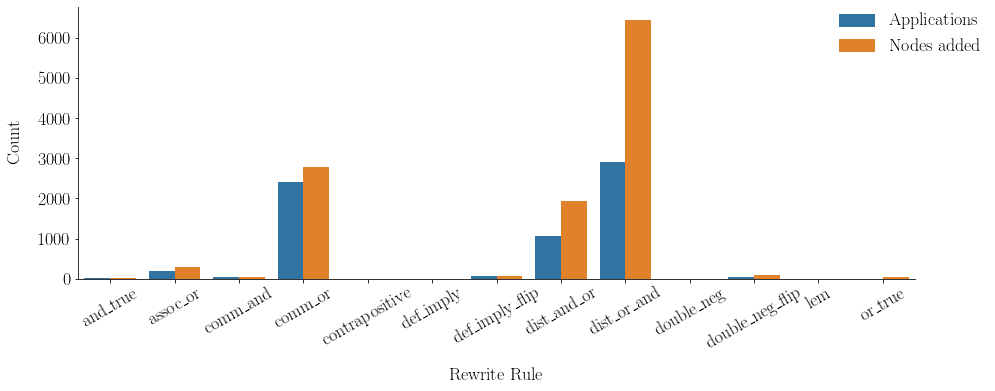

In [8]:
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"
df2["enodes_added"] = df2["num_enodes"].diff()
df2 = df2.groupby("action_name").agg('sum').reset_index()
df2 = df2[["action_name", "num_applications", "enodes_added"]]
df2 = df2.melt("action_name")
plt.rcParams['font.size'] = 18
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="action_name", y="value", hue="variable", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.set_xlabel("Rewrite Rule")
ax.set_ylabel("Count")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0)
leg = ax.axes.get_legend()
leg.set_frame_on(False)

new_labels = ['Applications', 'Nodes added']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig("sync/egg_limits_rules.pdf", bbox_inches='tight')

# Single-Task Performance

## Easy task

In [4]:
def smooth(scalars: list[float], weight=0.9) -> list[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

/tmp/ipykernel_8688/1651743327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop["Lang"] = "PROP"
/tmp/ipykernel_8688/1651743327.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_math["Lang"] = "MATH"


running egg for expr Or(x=Not(x=Not(x=And(x=And(x=True, y=True), y=And(x=True, y='r')))), y=Not(x=Not(x='i')))
ITERATION_LIMIT num_applications 2160 num_enodes 3590 num_eclasses 27
egg best cost: 3 in 6ms best expr:  Or(x='r', y='i')
running egg for expr Mul(x=Add(x=16, y=2), y=Mul(x=4, y=0))
NODE_LIMIT num_applications 11307 num_enodes 21871 num_eclasses 10104
egg best cost: 1 in 43ms best expr:  0


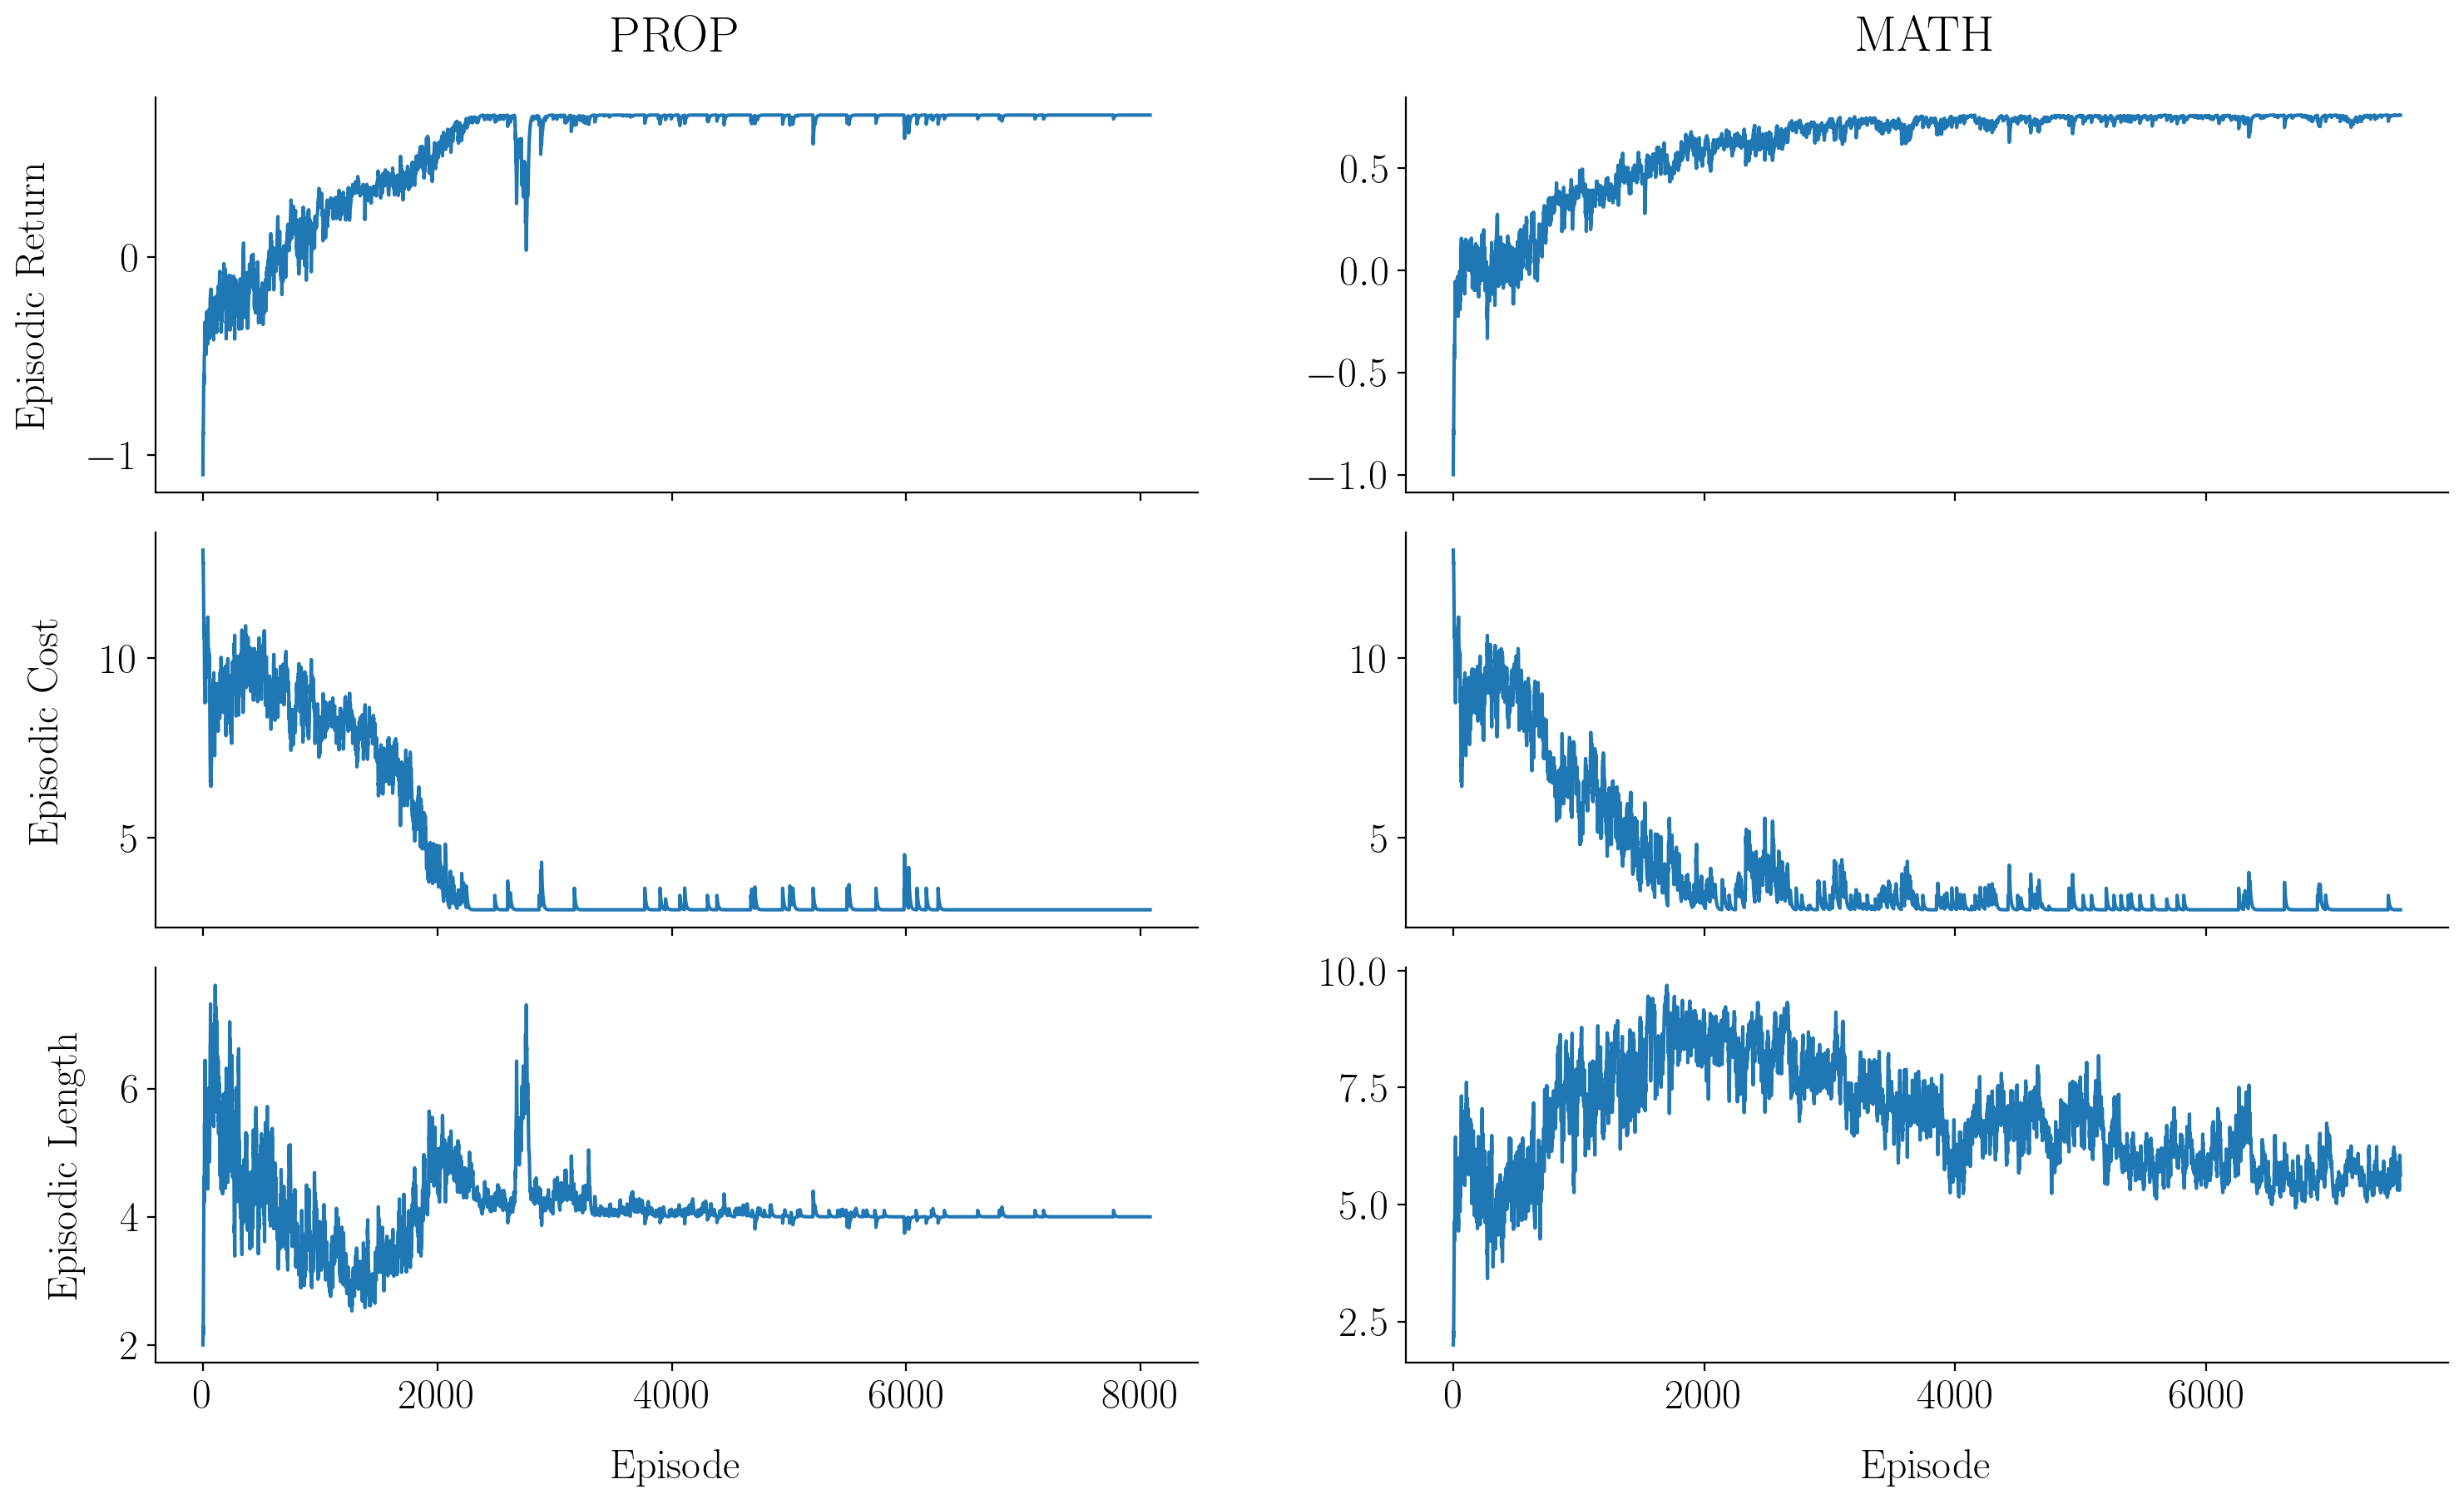

In [43]:
# Load log data
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'egraph-v0__ppo__1__1655144794']
df_prop["Lang"] = "PROP"
# TODO: change this
df_math = df[df['dir_name'] == 'egraph-v0__ppo__1__1655142666']
df_math["Lang"] = "MATH"

plang = PropLang()
psat_expr = plang.get_single_task_exprs().saturatable
psolver = EGraphSolver(lang=plang, expr=psat_expr)
p_best_cost, p_best_expr, p_num_applications, p_num_enodes = run_egg(plang, psat_expr)

mlang = MathLang()
msat_expr = mlang.get_single_task_exprs().saturatable
msolver = EGraphSolver(lang=mlang, expr=msat_expr)
m_best_cost, m_best_expr, m_num_applications, m_num_enodes = run_egg(mlang, msat_expr)

def smooth_tensorboard_plots(df):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist())
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist())
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist())
    df2 = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length, "Lang": df.iloc[0]["Lang"]})
    return df2

def plot_single_task_easy_grid(df_prop, df_math):
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length', 'charts/acc_rewrites']

    df_prop = df_prop.loc[df_prop['tag'].isin(chart_list)]
    df_math = df_math.loc[df_math['tag'].isin(chart_list)]

    df_prop = df_prop[df_prop["step"] < 130_000]
    df_math = df_math[df_math["step"] < 130_000]
    # find steps where episodic_cost is minimum
    # then get min of acc_rw of those rows
    # df_prop.groupby("step")
    df_prop_minlen = 7

    df_prop = smooth_tensorboard_plots(df_prop)
    df_math = smooth_tensorboard_plots(df_math)

    df_math_minlen = 4
    
    df_all = pd.concat([df_prop, df_math])

    df = pd.melt(df_all, id_vars=["Lang"], ignore_index=False)
    # plt.figure(figsize=(5, 10))
    g = sns.relplot(x=df.index, y="value", row="variable", col="Lang", kind="line", data=df, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)

    # g.set(xlabel="Episode")
    g.fig.subplots_adjust(wspace=.2, hspace=.1)
    ylabels = ["Episodic Return", "",
              "Episodic Cost", "",
              "Episodic Length", ""]

    for ind, ax in enumerate(g.axes.flatten()):
        if ind == 0:
            ax.set_title("PROP", pad=20, fontweight="bold")
        elif ind == 1:
            ax.set_title("MATH", pad=20, fontweight="bold")
        else:
            ax.set_title("")

        if ind not in [4, 5]:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind in [4, 5]:
            ax.set_xlabel("Episode")

    # create separate barplot
    # Lang, num_applications_egg, num_applications_omelette
    data = [["PROP", p_num_applications, df_prop_minlen],
            ["MATH", m_num_applications, df_math_minlen]]
    df = pd.DataFrame(data, columns=["Lang", "Egg", "Omelette"])   
    df = df.melt(["Lang"])
    return g, df

g, bpdf = plot_single_task_easy_grid(df_prop, df_math)
g.fig.savefig("sync/single_task_easy.pdf", bbox_inches='tight')

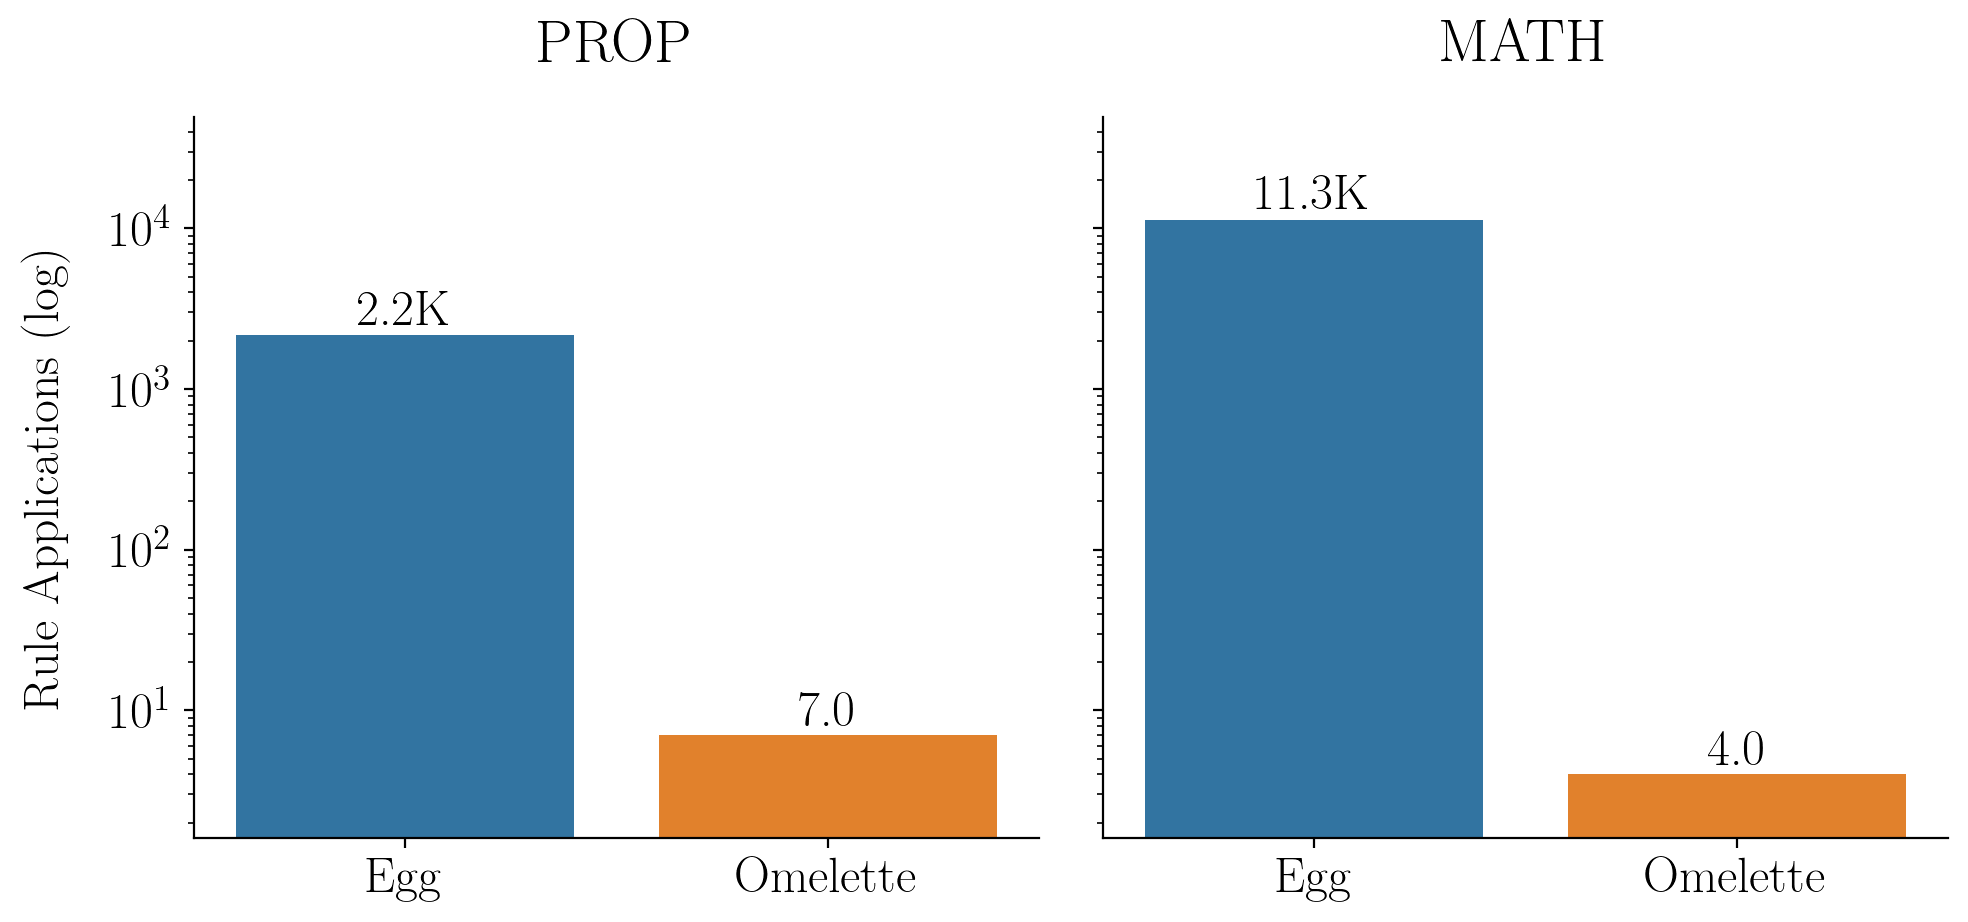

In [45]:
bp = sns.catplot(x="variable", y="value",
            col="Lang",
            kind="bar", data=bpdf, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():2}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps.pdf")


## Exploding Task

# Pretraining Graphs

### PROP

##### Dataset analysis

In [ ]:
def load_dataset(dataset_dir: str):
  files = os.listdir(dataset_dir)
  files.sort()
  keyf = lambda f: f.split("_")[0]

  files_grouped_by_expr = [list(expr_files) for gr, expr_files in groupby(files, key=keyf)]

  Row = namedtuple('Row', ['max_cost', 'min_cost', 'om_actions', 'egg_actions', 'action_mult', 'om_enodes', 'egg_enodes', 'enodes_mult', 'om_eclasses', 'egg_eclasses', 'eclasses_mult'])

  rows = []

  for group in files_grouped_by_expr:
    min_actions = len(group)
    d = torch.load(dataset_dir + "/" + group[-1])
    num_eclasses = int(torch.sum(d["x"][:, 0]).item())
    num_enodes = int(len(d["x"]) - num_eclasses)

    node_mult = (d.egg_enodes / num_enodes)
    class_mult = (d.egg_eclasses / num_eclasses)
    action_mult = (d.egg_rewrites / min_actions)

    rows.append(Row(max_cost=d.max_cost, min_cost=d.min_cost, om_actions=min_actions, egg_actions=d.egg_rewrites, action_mult=action_mult,
        om_enodes=num_enodes, egg_enodes=d.egg_enodes, enodes_mult=node_mult,
        om_eclasses=num_eclasses, egg_eclasses=d.egg_eclasses, eclasses_mult=class_mult))
    
  return pd.DataFrame(rows)

In [ ]:
df = load_dataset("../PropLang")
df = df[["action_mult", "enodes_mult", "eclasses_mult"]]
df_melted = pd.melt(df)
plt.figure(figsize = (15,8))
g = sns.boxplot(x='variable', y='value', data=df_melted)
g.set(ylabel="Multiplier", xlabel="Attribute", yscale="log")
plt.savefig("prop_data.pdf")

In [ ]:
df = load_dataset("../PropLang")
df = df[["min_cost", "max_cost"]]
df

##### Training/Test Accuracy Plots

In [ ]:
# Load log data
log_dir = "../lightning_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'prop']
df_math = df[df['dir_name'] == 'math']


In [ ]:
def plot_acc(df, title):
  g = sns.lineplot(data=df, x='step', y='value')
  g.set(title=title, ylabel="Accuracy", xlabel="Step")
  return g

In [ ]:
def plot_acc_grid(df1, df2):
  df1 = df1.loc[df1['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df2 = df2.loc[df2['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df_all = pd.concat([df1, df2])

  g = sns.relplot(x="step", y="value", col="tag", row="dir_name", kind="line", data=df_all);
  g.set(ylabel="Accuracy", xlabel="Step")
  return g

g = plot_acc_grid(df_prop, df_math)
plt.savefig("sup_acc.pdf")

In [ ]:
train_acc_df = df[df['tag'] =='acc/train_acc']
plot_acc(train_acc_df, "Training Accuracy")

In [ ]:
al_acc_df = df[df['tag'] =='acc/val_acc']


# Single-Task Performance

# Generalizability